In [26]:
# importing libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
# Setting up image augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,         
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)


In [28]:
# load training and validation data

train_generator = train_datagen.flow_from_directory(
    'data/birds/train',
    target_size=(224, 224),   # VGG16 input size
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    'data/birds/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [29]:
# Import the required libraries
import os

# Define the paths to the directories
train_directory = 'data/birds/train'
valid_directory = 'data/birds/valid'

# Get the list of class directories
class_directories = os.listdir(train_directory)

# Initialize a dictionary to store the count of training images for each class
class_count = {}

# Loop through each class directory and count training images
for class_name in class_directories:
    class_path = os.path.join(train_directory, class_name)
    class_count[class_name] = len(os.listdir(class_path))

# Find the top 3 classes with the highest count of training images
top_classes = sorted(class_count, key=class_count.get, reverse=True)[:3]

# Print the top 3 classes and their counts
for i, class_name in enumerate(top_classes, start=1):
    print(f"Top {i} class: {class_name} ({class_count[class_name]} images)")


Class with the highest training images: RUFOUS TREPE (263 images)


In [18]:
# Fine Tune - VGG16
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)


In [19]:
# Adding classification layers on top of VGG16
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')   # 3 classes
])


In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 21,138,243
Non-trainable params: 0
_________________________________________________________________


In [21]:
# compile and training the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=10,      
    validation_data=valid_generator
)


Epoch 1/10
16/16 [==============================] - 137s 8s/step - loss: 1.4493 - accuracy: 0.4491 - val_loss: 1.1946 - val_accuracy: 0.5333
Epoch 2/10
16/16 [==============================] - 137s 9s/step - loss: 1.0818 - accuracy: 0.3659 - val_loss: 0.8420 - val_accuracy: 0.3333
Epoch 3/10
16/16 [==============================] - 135s 8s/step - loss: 0.8326 - accuracy: 0.5613 - val_loss: 0.4995 - val_accuracy: 0.6667
Epoch 4/10
16/16 [==============================] - 135s 8s/step - loss: 0.7060 - accuracy: 0.6486 - val_loss: 0.3242 - val_accuracy: 0.8667
Epoch 5/10
16/16 [==============================] - 134s 8s/step - loss: 0.6988 - accuracy: 0.7048 - val_loss: 0.2245 - val_accuracy: 1.0000
Epoch 6/10
16/16 [==============================] - 132s 8s/step - loss: 0.4754 - accuracy: 0.8170 - val_loss: 0.3208 - val_accuracy: 0.8000
Epoch 7/10
16/16 [==============================] - 124s 8s/step - loss: 0.4099 - accuracy: 0.8503 - val_loss: 0.0998 - val_accuracy: 1.0000
Epoch 8/10
16

In [23]:
# explore model performance
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    'data/birds/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_loss, test_acc = model.evaluate(test_generator)
print("Test accuracy:", test_acc)



Found 15 images belonging to 3 classes.


1/1 [==============================] - 1s 1s/step - loss: 0.0076 - accuracy: 1.0000
Test accuracy: 1.0


In [24]:

from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = tf.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Generate classification report and confusion matrix
print(classification_report(true_classes, predicted_classes))
print(confusion_matrix(true_classes, predicted_classes))


1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.20      0.20      0.20         5
           2       0.40      0.40      0.40         5

    accuracy                           0.33        15
   macro avg       0.33      0.33      0.33        15
weighted avg       0.33      0.33      0.33        15

[[2 2 1]
 [2 1 2]
 [1 2 2]]


1/1 [==============================] - 1s 1s/step


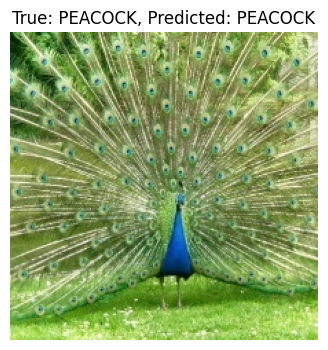

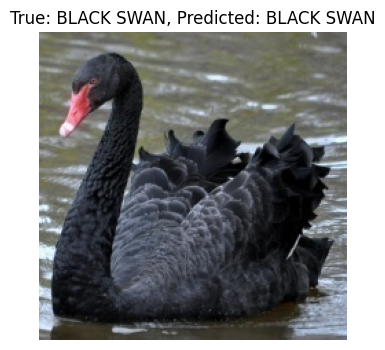

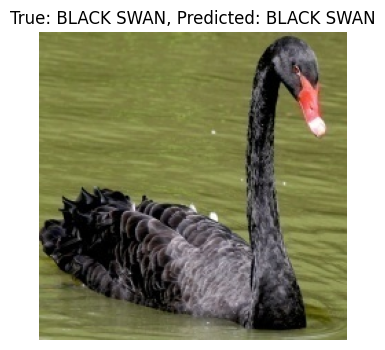

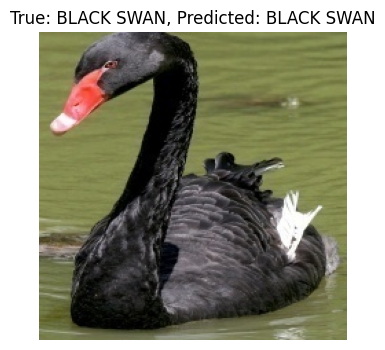

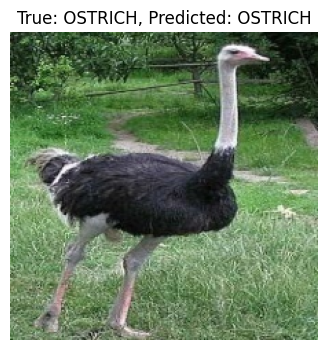

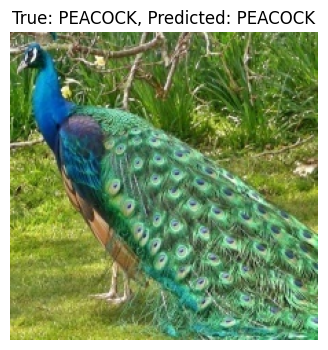

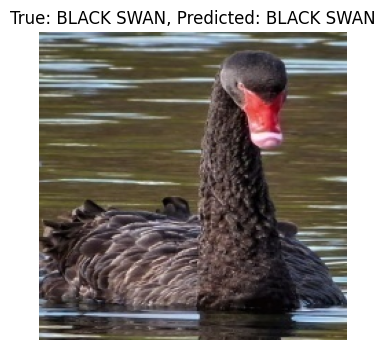

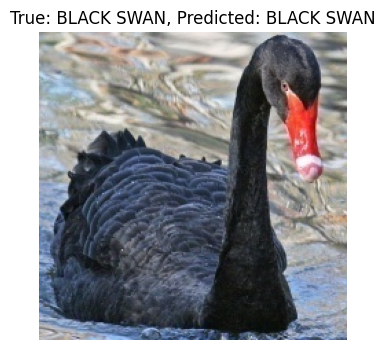

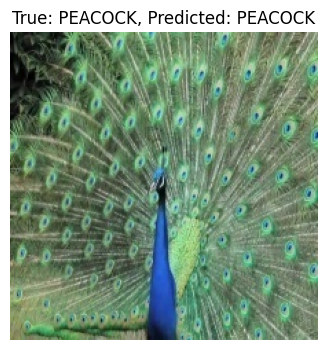

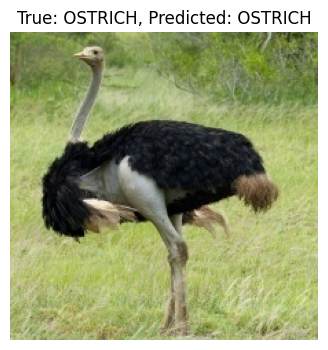

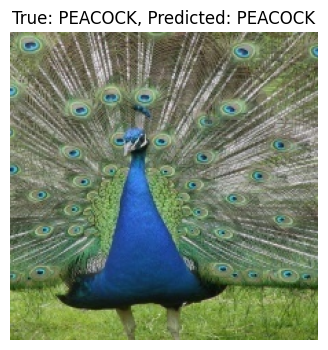

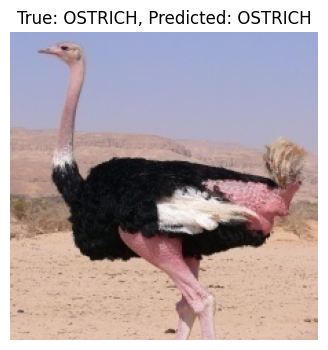

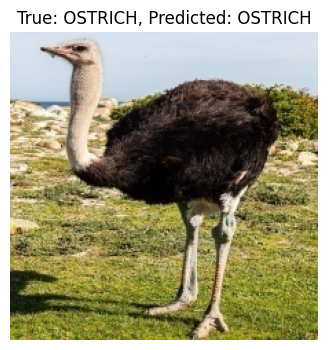

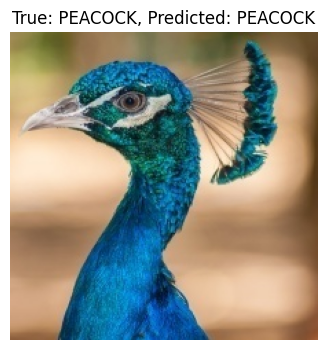

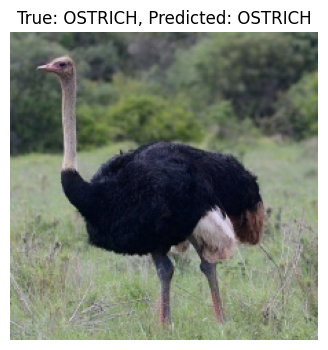

In [25]:
# Visualization
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test images and labels
images, labels = next(iter(test_generator))

# Predict class probabilities
probs = model.predict(images)

# Get class names
class_names = list(test_generator.class_indices.keys())

# Visualize a few examples
for i in range(images.shape[0]):
    plt.figure(figsize=(4, 4))
    plt.imshow(images[i])
    plt.title(f'True: {class_names[np.argmax(labels[i])]}, Predicted: {class_names[np.argmax(probs[i])]}')
    plt.axis('off')
    plt.show()
